<a href="https://colab.research.google.com/github/marziye-jalili/deep_learning/blob/main/dogs_cats_fine_tuning_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading a Dataset :https://www.kaggle.com/c/dogs-vs-cats/data

![](https://image.cnnturk.com/i/cnnturk/75/0x555/546e4723f493b81e809b4479.jpg)

# loading all the required libraries

In [11]:
# basic librareis
import zipfile
import glob
import os
import pandas as pd
import numpy as np
from PIL import Image
import random

# plotting and visualizations
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno

from sklearn.utils import shuffle

# preprocessing
from keras.preprocessing.image import (ImageDataGenerator,img_to_array,array_to_img,load_img)
from sklearn.model_selection import train_test_split

# metrics
from sklearn.metrics import (confusion_matrix,classification_report,accuracy_score,f1_score)
import seaborn as sns

# modeling
import tensorflow as tf
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import VGG16
from urllib.request import urlretrieve
from keras import layers, models, optimizers
from keras.layers import  Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping,LearningRateScheduler
from keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf

print('Done!')

Done!


# Upload dataset

In [12]:
# extraction of train and test data from zipfiles to data folder
extract_path = '/content/dataset/'
zip_file_path = '/content/test1.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('Test1 Extraction is completed\n')

extract_path = '/content/dataset/'
zip_file_path = '/content/train.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('Train Extraction is completed\n')

Test1 Extraction is completed

Train Extraction is completed



In [189]:
# Total number of images in train and test datasets
train_dir = '/content/dataset/train'
test_dir = '/content/dataset/test1'

print("Total Images in Train and Test Data...")
print(f'No. of Train Images: {len(os.listdir(train_dir))}')
print(f'No. of Test Images: {len(os.listdir(test_dir))}\n')

Total Images in Train and Test Data...
No. of Train Images: 25000
No. of Test Images: 12500



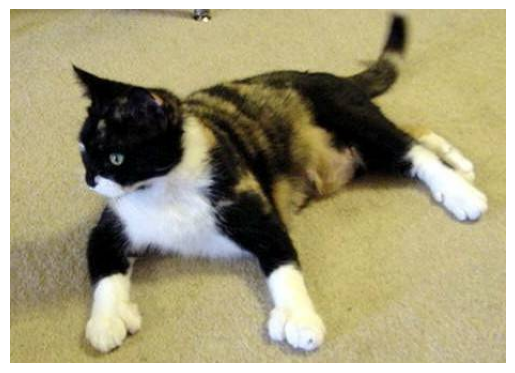

In [190]:
image_number = 59
image_path = os.path.join(train_dir, f'cat.{image_number}.jpg')
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [191]:
# Category and filepath extraction helper functions
def category(path):
    return [file.split('.')[0] for file in os.listdir(path)]

def filename(path):
    return [file for file in os.listdir(path)]

# Image names and labels
x_train_imgname = filename(train_dir)
x_test_imgname = filename(test_dir)
y_train_label = category(train_dir)

# Creation of total dataframe and submission dataframe
print('\nStoring image data into dataframes...\n')
train_image_df = pd.DataFrame({'filename': x_train_imgname, 'category': y_train_label})
submission_image_df = pd.DataFrame({'filename': x_test_imgname})

print('Training image names and labels are read to train_image_df\n')
print('Testing image names are read to submission_image_df\n')


Storing image data into dataframes...

Training image names and labels are read to train_image_df

Testing image names are read to submission_image_df



In [192]:
#Helper funtions for image path,id, category data extractions and Image visualizations
def img_path(directory):
    paths = []
    cate = []
    ID_no = []
    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        paths.append(path)
        cate.append(file.split('.')[0])
        ID_no.append(file.split('.')[1])
    return ID_no, paths, cate

def showImages(data, num_row=3, num_col=3, name='any', subtitle='off'):

    cat_df, dog_df = data[data['Category'] == 'cat'], data[data['Category'] == 'dog']

    if name == 'dog':
        X, Y = dog_df['img_paths'], dog_df['ID_no']
    elif name == 'cat':
        X, Y = cat_df['img_paths'], cat_df['ID_no']
    else:
        X, Y = data['img_paths'], data['ID_no']

    (X_rand, Y_rand) = shuffle(X, Y)

    fig, ax = plt.subplots(num_row, num_col, figsize=(15,2), dpi=100)
    fig.patch.set_facecolor('#f5f6f6')
    axes = ax.ravel()

    for idx, ax in enumerate(axes):
        x = load_img(X_rand.iloc[idx], target_size=(224, 224))
        ax.imshow(x)
        if subtitle == 'on':
            ax.set_title("{}".format(Y_rand.iloc[idx]))
        else:
            ax.set_title('')
        ax.axis('off')
        plt.subplots_adjust(wspace=0)
        del x
    plt.subplots_adjust(wspace=0, hspace=0)
    return None
print('Done!')

Done!


In [193]:
# Implementing above function over train data set
ID_no, img_paths, train_images = img_path(train_dir)

print('\nCreating a dataframe for training image visualization in a grid...\n')

# Creating a new dataframe for data visualization
visual_df = pd.DataFrame({'ID_no': ID_no, 'Category': train_images, 'img_paths': img_paths})

print(visual_df.head(15))


Creating a dataframe for training image visualization in a grid...

    ID_no Category                             img_paths
0    1810      dog   /content/dataset/train/dog.1810.jpg
1    1142      cat   /content/dataset/train/cat.1142.jpg
2    1529      dog   /content/dataset/train/dog.1529.jpg
3    9101      dog   /content/dataset/train/dog.9101.jpg
4    3897      cat   /content/dataset/train/cat.3897.jpg
5     549      cat    /content/dataset/train/cat.549.jpg
6   11825      cat  /content/dataset/train/cat.11825.jpg
7     466      cat    /content/dataset/train/cat.466.jpg
8    3295      cat   /content/dataset/train/cat.3295.jpg
9    5546      dog   /content/dataset/train/dog.5546.jpg
10   4653      cat   /content/dataset/train/cat.4653.jpg
11   5058      cat   /content/dataset/train/cat.5058.jpg
12   1815      dog   /content/dataset/train/dog.1815.jpg
13   5920      cat   /content/dataset/train/cat.5920.jpg
14   7593      dog   /content/dataset/train/dog.7593.jpg


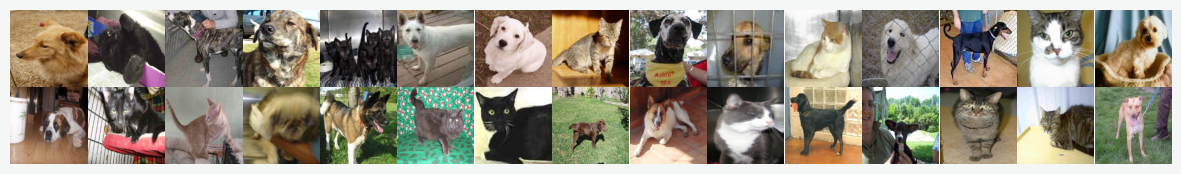

In [194]:
showImages(visual_df,2,15, name = 'Dogs and Cat', subtitle = 'off')

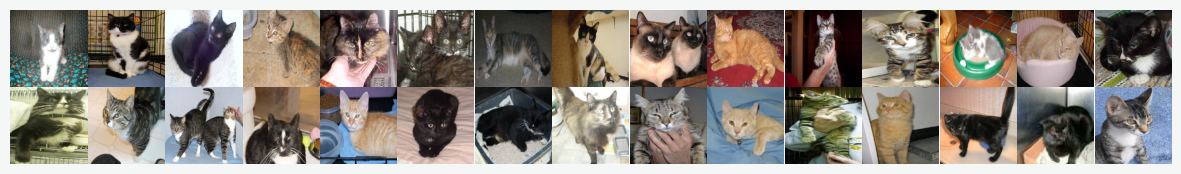

In [195]:
showImages(visual_df, 2, 15, name='cat', subtitle='off')

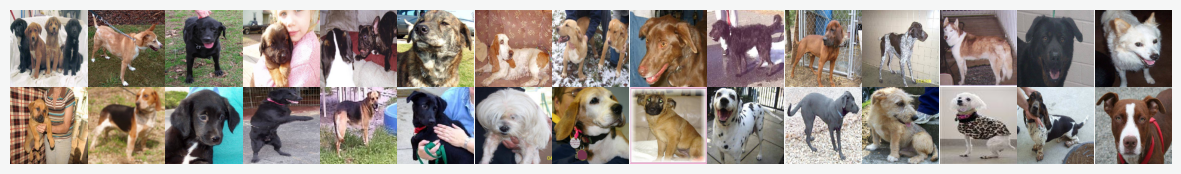

In [196]:
showImages(visual_df,2,15, name = 'dog', subtitle = 'off')

# train_test_split

In [197]:
# Data split into train data and validation data
train_valid_df, test_df = train_test_split(train_image_df, test_size = 0.04)
train_df, valid_df = train_test_split(train_valid_df, test_size = 0.2)

train_images = train_df.shape[0]
valid_images = valid_df.shape[0]
holdon_images = test_df.shape[0]
test_images = submission_image_df.shape[0]

print('\nNumber of Training Images: ' + str(train_images))
print('\nNumber of Validating Images: ' + str(valid_images))
print('\nNumber of Holdon Images: ' + str(holdon_images))
print('\nNumber of Testing Images: ' + str(test_images))


Number of Training Images: 19200

Number of Validating Images: 4800

Number of Holdon Images: 1000

Number of Testing Images: 12500


In [198]:
# Counting the number of dog and cat images in each set
train_dog_images = train_df[train_df['category'] == 'dog'].shape[0]
train_cat_images = train_df[train_df['category'] == 'cat'].shape[0]

valid_dog_images = valid_df[valid_df['category'] == 'dog'].shape[0]
valid_cat_images = valid_df[valid_df['category'] == 'cat'].shape[0]

holdon_dog_images = test_df[test_df['category'] == 'dog'].shape[0]
holdon_cat_images = test_df[test_df['category'] == 'cat'].shape[0]

print('\nNumber of Training Dog Images: ' + str(train_dog_images))
print('Number of Training Cat Images: ' + str(train_cat_images))

print('\nNumber of Validating Dog Images: ' + str(valid_dog_images))
print('Number of Validating Cat Images: ' + str(valid_cat_images))

print('\nNumber of Holdon Dog Images: ' + str(holdon_dog_images))
print('Number of Holdon Cat Images: ' + str(holdon_cat_images))


Number of Training Dog Images: 9614
Number of Training Cat Images: 9586

Number of Validating Dog Images: 2384
Number of Validating Cat Images: 2416

Number of Holdon Dog Images: 502
Number of Holdon Cat Images: 498


# Image agumentation data preparation with ImageDataGenerator

In [199]:
# Set seed for reproducibility
seed_value =1
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

img_size =224
batch_size=128
# train
train_aug_map = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1/255,
    preprocessing_function=preprocess_input)

vgg_train_data = train_aug_map.flow_from_dataframe(
    train_df, train_dir,
    x_col='filename',
    y_col='category',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')
# valid
valid_aug_map = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1/255)

vgg_valid_data = valid_aug_map.flow_from_dataframe(
    valid_df, train_dir,
    x_col='filename',
    y_col='category',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical')
# test

test_aug_map = ImageDataGenerator(preprocessing_function=preprocess_input,rescale=1/255)

vgg_test_data = test_aug_map.flow_from_dataframe(
    test_df, train_dir,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(img_size, img_size),
    shuffle=False)

Found 19200 validated image filenames belonging to 2 classes.
Found 4800 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames.


# VGG16

In [25]:
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#vgg16_model = VGG16(weights=vgg16_weights_path, include_top=False, input_shape=(224, 224, 3))

# Freeze the first few layers (optional)
for layer in vgg16_model.layers[:5]:
    layer.trainable = False

model_vgg16 = models.Sequential([
    vgg16_model,
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')
])

# Compile the VGG16 model with Adam optimizer
loss = 'categorical_crossentropy'
optimizer = optimizers.Adam(1e-5)
metrics = ['accuracy']
model_vgg16.compile(loss = loss, optimizer = optimizer, metrics = metrics)

In [26]:
model_vgg16.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                      

# learing rate setting

In [27]:
epoch = 50
learning_rate = 3e-5
lr_start = 0.001
lr_min = 0.000001
lr_max = 3e-5
lr_rampup_epochs = 1
lr_sustain_epochs = 1
lr_exp_decay = .8
def lrfn(epoch):
    if epoch < lr_rampup_epochs:
        lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
    elif epoch < lr_rampup_epochs + lr_sustain_epochs:
        lr = lr_max
    else:
        lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
    return lr

print('Done!')

Done!


# train and validate Pre-trained VGG16 model

In [30]:
earlystop = EarlyStopping(patience=5)
lr_callback = LearningRateScheduler(lrfn, verbose=True)
callbacks = [earlystop, lr_callback]

history_vgg16 = model_vgg16.fit(vgg_train_data, epochs=20,
                                validation_data=vgg_valid_data,
                                validation_steps=valid_images // batch_size,
                                steps_per_epoch=train_images // batch_size,
                                callbacks=callbacks)
print('\nDone!\n')


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
150/150 [==============================] - 228s 2s/step - loss: 0.5319 - accuracy: 0.7256 - val_loss: 0.5144 - val_accuracy: 0.7061 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 3e-05.
Epoch 2/20
150/150 [==============================] - 228s 2s/step - loss: 0.4234 - accuracy: 0.7977 - val_loss: 0.4203 - val_accuracy: 0.8184 - lr: 3.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 3e-05.
Epoch 3/20
150/150 [==============================] - 229s 2s/step - loss: 0.4048 - accuracy: 0.8154 - val_loss: 0.3858 - val_accuracy: 0.8313 - lr: 3.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 2.4200000000000002e-05.
Epoch 4/20
150/150 [==============================] - 227s 2s/step - loss: 0.3860 - accuracy: 0.8250 - val_loss: 0.3669 - val_accuracy: 0.8488 - lr: 2.4200e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9560000000000006e-05.
Epoch 5/20

In [31]:
model_vgg16.save('vgg16_model.keras')
print('\nModel saved successfully!\n')


Model saved successfully!



In [123]:
# Print validation results from training history
print("Validation Loss (last epoch):", history_vgg16.history['val_loss'][-1])
print("Validation Accuracy (last epoch):", history_vgg16.history['val_accuracy'][-1])

Validation Loss (last epoch): 0.34005945920944214
Validation Accuracy (last epoch): 0.8597972989082336


# Model charts

In [200]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize is None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks is False:
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('#f5f6f6')
    sns.heatmap(cf, annot=box_labels, fmt="", linewidths=1, square=True, linecolor='#f5f6f6',
                cmap=cmap, cbar=cbar, annot_kws={'size': 12},
                xticklabels=categories,
                yticklabels=categories, ax=ax)

    if xyplotlabels:
        plt.ylabel('True label', {'size': 12})
        plt.xlabel('Predicted label' + stats_text, {'size': 12})
    else:
        plt.xlabel(stats_text, {'size': 12})

    if categories:
        ax.set_xticks(np.arange(len(categories)) + 0.5, minor=False)
        ax.set_yticks(np.arange(len(categories)) + 0.5, minor=False)
        ax.set_xticklabels(categories, fontsize=12)
        ax.set_yticklabels(categories, fontsize=12)

    plt.show()

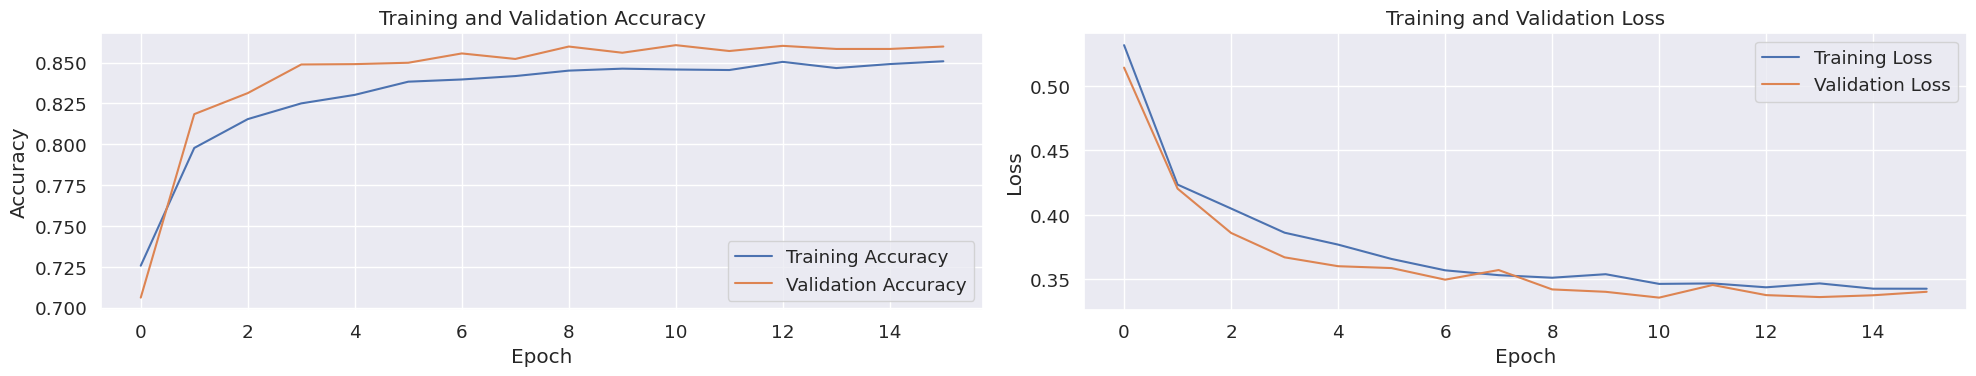

In [201]:
plt.figure(figsize=(20, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# VGG16 predictions with confusion matrix

In [202]:
vgg_pred = model_vgg16.predict(vgg_test_data)
test_df['vgg_pred'] = np.argmax(vgg_pred, axis=-1)
labels = dict((v, k) for k, v in vgg_train_data.class_indices.items())
test_df['vgg_pred'] = test_df['vgg_pred'].map(labels)
print('\nDone!\n')

32/32 [==============================] - 4s 118ms/step

Done!



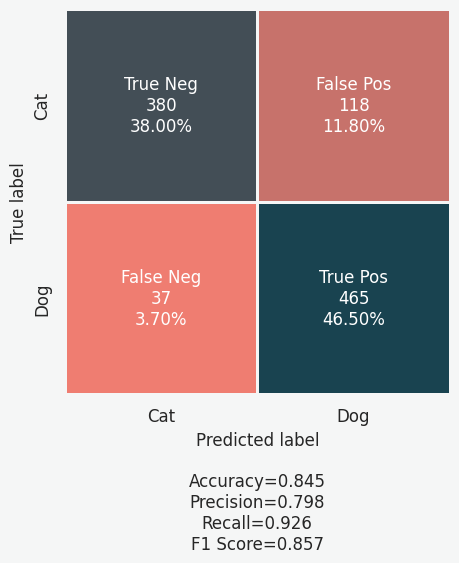

In [203]:
colors = ['#EF7D71', '#194350']
vgg_cf_matrix = confusion_matrix(test_df['category'], test_df['vgg_pred'])
my_cols = [colors[0], colors[1]]

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Cat', 'Dog']
make_confusion_matrix(vgg_cf_matrix, figsize=(10, 5),
                      group_names=labels, cbar=False,
                      cmap=matplotlib.colors.LinearSegmentedColormap.from_list("", my_cols),
                      categories=categories,
                      title='vgg16 comfusion matrix')

# Testing the model on the test dataset

In [204]:
vgg_sub_aug_map = ImageDataGenerator(preprocessing_function = preprocess_input)
vgg_sub_data = vgg_sub_aug_map.flow_from_dataframe(
             submission_image_df, test_dir,
             x_col = 'filename',
             y_col = None,
             class_mode = None,
             target_size = (img_size, img_size),
             shuffle = False)

Found 12500 validated image filenames.


In [206]:
from keras.models import load_model
model_path = 'vgg16_model.keras'
loaded_model = load_model(model_path)

test_probabilities = loaded_model.predict(vgg_sub_data)
threshold = 0.5
test_labels = (test_probabilities > threshold).astype(int)
submission_image_df['predicted_category'] = test_labels[:, 1]
print(submission_image_df.head())

391/391 [==============================] - 47s 120ms/step
    filename  predicted_category
0  11608.jpg                   0
1   1280.jpg                   1
2   8934.jpg                   1
3  10225.jpg                   1
4     64.jpg                   1


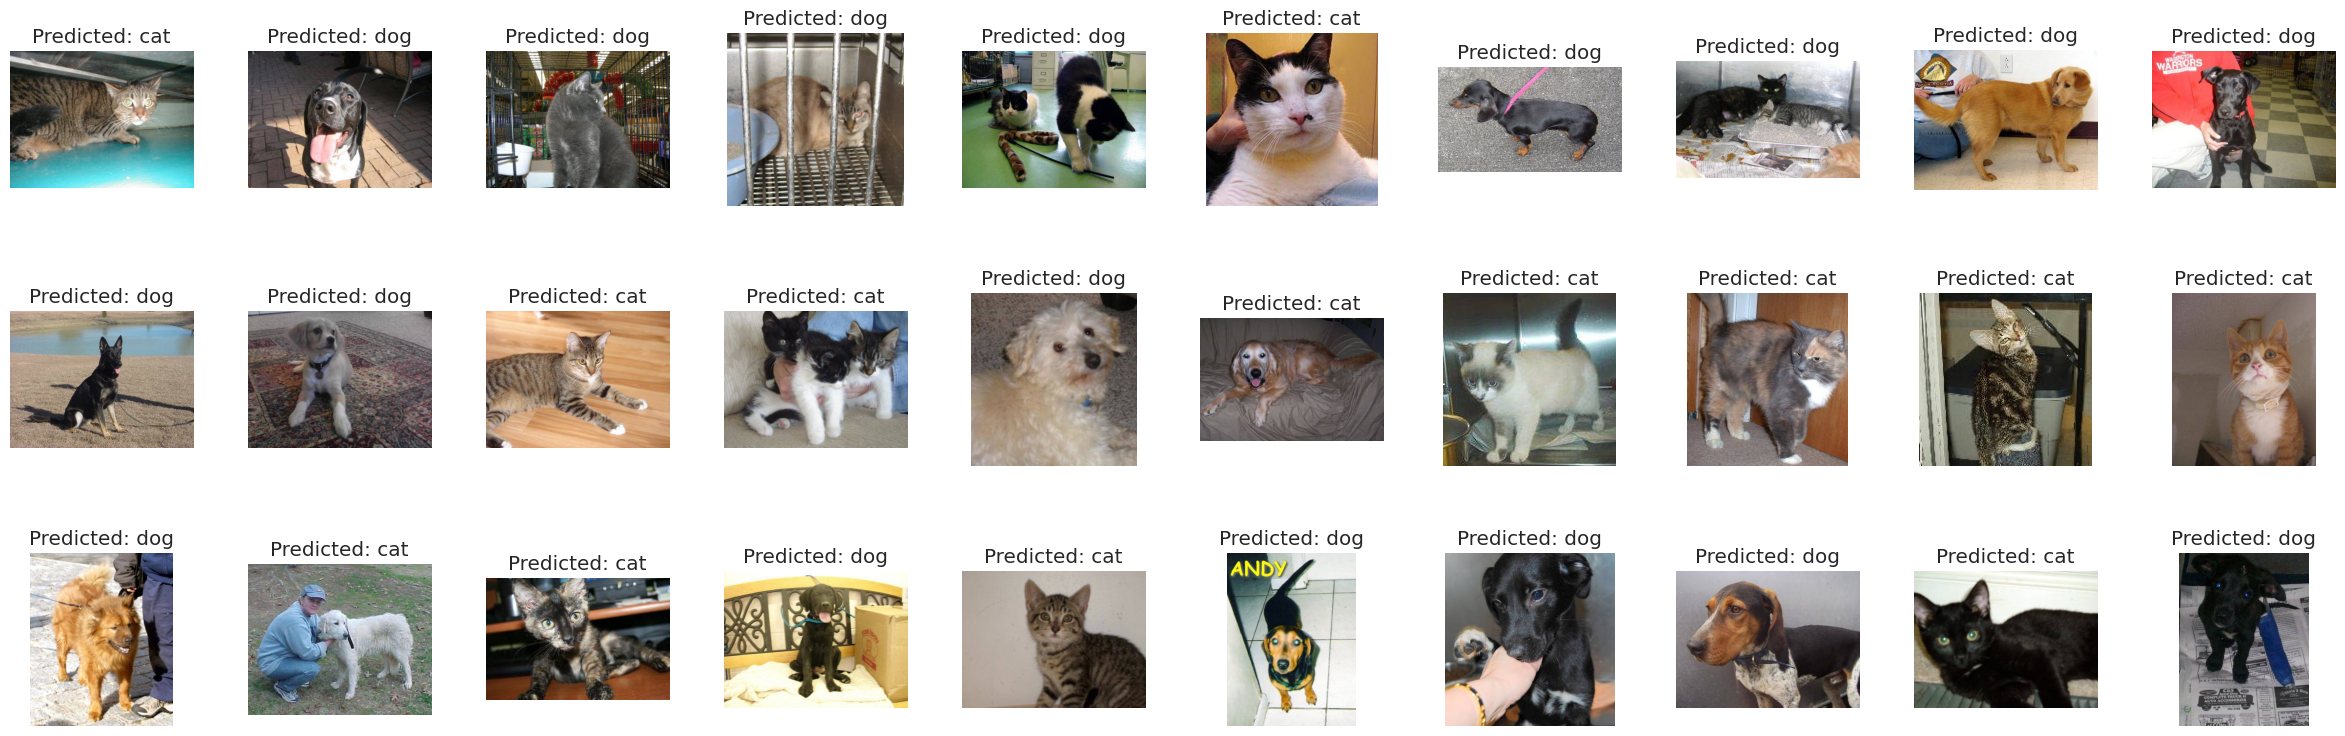

In [207]:
num_rows = 3
num_cols = 10

# Create a grid of images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 9))

# Print the image specifications and predicted labels
for index, row in submission_image_df.head(num_rows * num_cols).iterrows():
    img_path = os.path.join(test_dir, row['filename'])
    img = Image.open(img_path)

    # Calculate the location in the grid
    row_index = index // num_cols
    col_index = index % num_cols

    # Map predicted category to human-readable label
    predicted_label = 'dog' if row['predicted_category'] == 1 else 'cat'

    # Print the image in the desired location
    axes[row_index, col_index].imshow(img)
    axes[row_index, col_index].axis('off')

    # Print the predicted and actual labels
    axes[row_index, col_index].set_title(f"Predicted: {predicted_label}")

# Adjust the spacing between images
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()
